In [1]:
if True:
    import os
    os.environ["PYSPARK_SUBMIT_ARGS"]='--packages com.databricks:spark-csv_2.10:1.3.0 pyspark-shell'
    execfile(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py'))
    import os
    import sys
else:
    os.environ['SPARK_HOME'] = '/usr/lib/spark'
    sys.path.insert(0, '/usr/lib/spark/python/lib/py4j-0.9-src.zip')
    sys.path.insert(0, '/usr/lib/spark/python/')
    sys.path.insert(0, '/usr/local/lib64/python2.7/site-packages')
    sys.path.insert(0,'/usr/local/lib/python2.7/site-packages')
    
    from pyspark import SparkContext
    from pyspark.sql import SQLContext, HiveContext
    
    try: sc = SparkContext()
    except: None    
    sqlc = SQLContext(sc)
    spark = sqlc

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.0.2
      /_/

Using Python version 2.7.6 (default, Mar 22 2014 22:59:56)
SparkSession available as 'spark'.


In [2]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, MapType
import pyspark.sql.functions as F

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import seaborn as sns

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [5]:
import numpy as np
import pandas as pd
import time
import json


In [6]:
from operator import add
from pyspark.sql.types import *

In [7]:
from pyspark.mllib.recommendation import Rating
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel
from datetime import datetime

In [8]:
import sklearn.metrics.pairwise as sk_pairwise
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import heapq
from random import sample

# Load model

In [9]:
model = MatrixFactorizationModel.load(sc,"lab_12/cache/als40_full_ratings.model")

In [14]:
item_fct = model.productFeatures()

In [16]:
item_fct.count()

24021

# Get all vectors to driver

In [91]:
#item_lst = item_fct.sample(False, 0.1).collect()
item_lst = item_fct.collect()

In [92]:
len(item_lst)

24021

In [93]:
item_lst[0]

(4,
 array('d', [-0.0041213748045265675, -0.6034937500953674, 0.937390148639679, 0.35463857650756836, 0.4776104688644409, -0.2850543260574341, 0.30313578248023987, 0.12848421931266785, 0.15677578747272491, 0.30346688628196716, 0.0035732006654143333, -0.3058040738105774, -0.15403880178928375, -0.4491393566131592, 0.46761423349380493, 0.40088990330696106, -0.13779129087924957, 0.21125473082065582, 0.3451184928417206, 0.083947092294693, -0.10666617751121521, 0.37904658913612366, 0.1505107581615448, -0.04928489774465561, -0.08550386875867844, -0.017986591905355453, -0.019600320607423782, 0.4840761423110962, -0.22067666053771973, -0.7297072410583496, -0.07998983561992645, -0.11464568972587585, 0.3434155583381653, -0.20695321261882782, 0.023287994787096977, -0.2099648267030716, -0.5393193960189819, -0.5388100743293762, -0.4608010947704315, 0.1486714780330658]))

# Build similarity matrix

In [94]:
all_vecs = [r[1] for r in item_lst]
item_ids = [r[0] for r in item_lst]

In [95]:
item_mx = np.vstack(all_vecs)

In [96]:
del all_vecs
del item_lst

In [97]:
item_mx.shape

(24021, 40)

In [98]:
%%time
i2i_sim = sk_pairwise.cosine_similarity(item_mx)

CPU times: user 20.3 s, sys: 1.6 s, total: 21.9 s
Wall time: 12.2 s


# Find top K for each item

In [99]:
k_neighbors = 100

In [103]:
records = []

In [104]:
%%time
for j in range(len(item_ids)):
    j_id = item_ids[j]
    j_topk = heapq.nlargest(k_neighbors + 1, enumerate(i2i_sim[j,:]), lambda x: x[1])[1:]
    j_topk_ids = [(j_id, item_ids[s], js_sim, sim_rank) for sim_rank,(s,js_sim) in enumerate(j_topk)]
    records.extend(j_topk_ids)
    if j % 1000 == 0:
        print datetime.now(), j

2016-12-24 16:22:19.399826 0
2016-12-24 16:22:35.757786 1000
2016-12-24 16:22:52.025992 2000
2016-12-24 16:23:08.354838 3000
2016-12-24 16:23:24.652834 4000
2016-12-24 16:23:40.970476 5000
2016-12-24 16:23:57.603091 6000
2016-12-24 16:24:13.898777 7000
2016-12-24 16:24:30.131809 8000
2016-12-24 16:24:46.450478 9000
2016-12-24 16:25:02.878154 10000
2016-12-24 16:25:19.108225 11000
2016-12-24 16:25:35.356349 12000
2016-12-24 16:25:51.642053 13000
2016-12-24 16:26:07.979632 14000
2016-12-24 16:26:24.287750 15000
2016-12-24 16:26:40.545799 16000
2016-12-24 16:26:56.879314 17000
2016-12-24 16:27:13.126176 18000
2016-12-24 16:27:29.488262 19000
2016-12-24 16:27:45.732020 20000
2016-12-24 16:28:02.007987 21000
2016-12-24 16:28:18.306145 22000
2016-12-24 16:28:34.682139 23000
2016-12-24 16:28:50.973965 24000
CPU times: user 6min 34s, sys: 2.23 s, total: 6min 37s
Wall time: 6min 31s


In [105]:
records[:3]

[(4, 7815, 0.84881378026830201, 0),
 (4, 24898, 0.8380779357448499, 1),
 (4, 9119, 0.82301835442163807, 2)]

In [106]:
top_k_df = pd.DataFrame.from_records(records, columns=['item1', 'item2', 'similarity', 'sim_rank'])

In [107]:
top_k_df.head()

,item1,item2,similarity,sim_rank
0,4,7815,0.848814,0
1,4,24898,0.838078,1
2,4,9119,0.823018,2
3,4,6101,0.817469,3
4,4,18471,0.813825,4


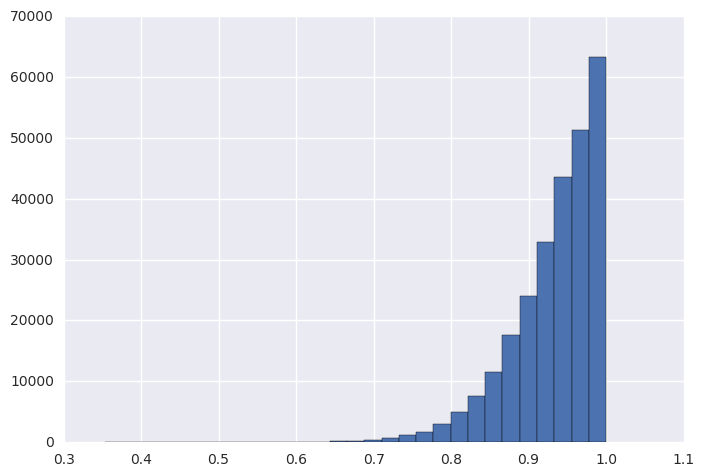

In [112]:
top_k_df.similarity[top_k_df.sim_rank<=10].hist(bins=30)

In [108]:
#fpath = "/data/home/taras.svirsky/lab12/data/i2itop%d.csv" % (k_neighbors, )
#top_k_df.to_csv(fpath, index=False)

# Cluster all items

## select number of clusters

In [177]:
sample_idx = sample(range(item_mx.shape[0]), 2000)

In [178]:
n_clusters = 20

In [179]:
km = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_jobs=6)

In [180]:
clusters = km.fit_predict(item_mx)

In [181]:
km.inertia_

15670.792467403147

In [185]:
%%time
silhouette_avg = silhouette_score(item_mx, clusters)
print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

('For n_clusters =', 20, 'The average silhouette_score is :', 0.013414143326949471)
CPU times: user 39.8 s, sys: 3.64 s, total: 43.5 s
Wall time: 33.8 s


In [189]:
sample_item_mx = item_mx#item_mx #item_mx[sample_idx,:]
sample_clusters = clusters#clusters #clusters[sample_idx]

In [190]:
%%time
sample_silhouette_values = silhouette_samples(sample_item_mx, sample_clusters)

CPU times: user 39.9 s, sys: 3.65 s, total: 43.5 s
Wall time: 33.9 s


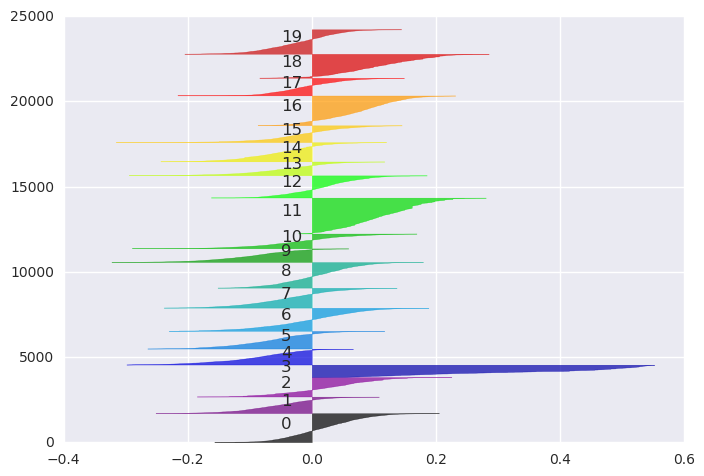

In [191]:
fig, ax1 = plt.subplots(1, 1)
#fig.set_size_inches(18, 7)
y_lower = 10
for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[sample_clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

In [168]:
clustering_res = []

In [194]:
sample_idx = sample(range(item_mx.shape[0]), 2000)
for n_clusters in range(15, 25):
    km = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_jobs=6)
    clusters = km.fit_predict(item_mx)
    wcss = km.inertia_
    sample_item_mx = item_mx#item_mx #item_mx[sample_idx,:]
    sample_clusters = clusters#clusters #clusters[sample_idx]
    silhouette_avg = silhouette_score(sample_item_mx, sample_clusters)
    print("n_clusters =", n_clusters, "silhouette_score =", silhouette_avg, "wcss =", wcss)
    clustering_res.append((n_clusters, wcss, silhouette_avg))
    

('n_clusters =', 15, 'silhouette_score =', 0.02587049443114452, 'wcss =', 16191.034606435845)
('n_clusters =', 16, 'silhouette_score =', 0.02010127245188157, 'wcss =', 16075.850747498305)
('n_clusters =', 17, 'silhouette_score =', 0.023202851823801354, 'wcss =', 15964.603907351624)
('n_clusters =', 18, 'silhouette_score =', 0.01772213966121091, 'wcss =', 15858.513963916974)
('n_clusters =', 19, 'silhouette_score =', 0.017747108883665558, 'wcss =', 15759.922297499284)
('n_clusters =', 20, 'silhouette_score =', 0.013414143326949471, 'wcss =', 15670.792467403147)
('n_clusters =', 21, 'silhouette_score =', 0.012841865379266173, 'wcss =', 15580.264988279549)
('n_clusters =', 22, 'silhouette_score =', 0.013029489561370266, 'wcss =', 15494.063970424508)
('n_clusters =', 23, 'silhouette_score =', 0.014396428168725866, 'wcss =', 15416.019610147025)
('n_clusters =', 24, 'silhouette_score =', 0.01163461735637277, 'wcss =', 15344.358031498221)


In [199]:
cdf = pd.DataFrame.from_records(clustering_res[-10:], columns=['n_clusters','wcss','silhouette_score'])

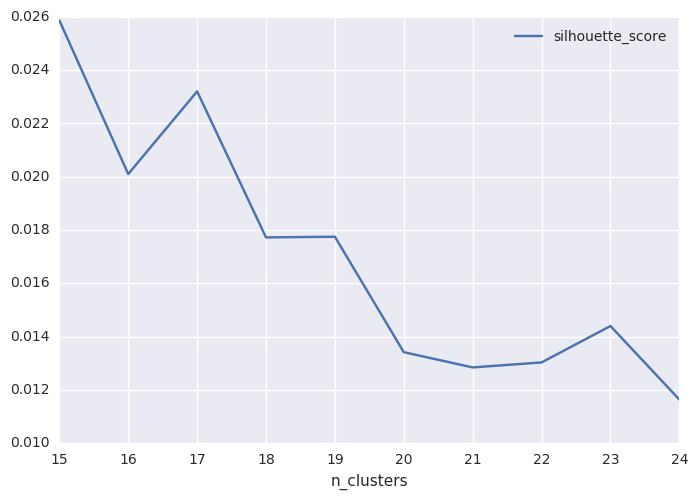

In [200]:
cdf.plot(x='n_clusters', y='silhouette_score')

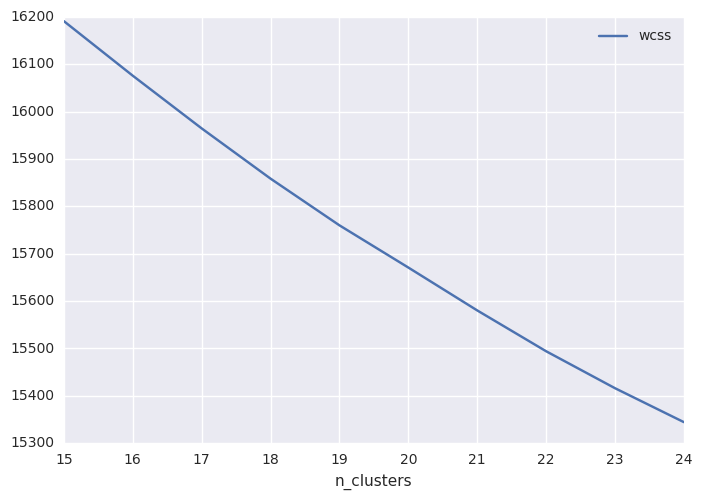

In [201]:
cdf.plot(x='n_clusters', y='wcss')

In [193]:
#cdf_base = cdf

# Save final clustering

In [202]:
km = KMeans(n_clusters=20, init='k-means++', random_state=42, n_jobs=6)
clusters = km.fit_predict(item_mx)

In [203]:
icdf = pd.DataFrame.from_dict({'item':item_ids, 'cluster':clusters})

In [206]:
res = icdf.sort_values(by='item')[['item','cluster']]

In [207]:
res.to_csv("/data/home/taras.svirsky/lab12/data/i_cluster.csv", index=False)

In [212]:
icdf.groupby('cluster')['item'].agg(len)

cluster
0     1694
1      962
2     1137
3      718
4      928
5     1030
6     1350
7     1162
8     1498
9      791
10     861
11    2097
12    1296
13     804
14    1120
15     982
16    1738
17    1026
18    1397
19    1430
Name: item, dtype: int64